# Mini-Project #1 - Deep Learning

## Antonin GAY - MVA 2018-19

## All the coded functions

I'll put here all the coded functions needed in the next part, in order for them to be available.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm import tqdm

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Deconv2D
from keras.optimizers import SGD, Adam


Using TensorFlow backend.


### Creation of figures

In [2]:
# %load mp1_figures

def generate_a_drawing(figsize, u, v, noise=0.0):
    """ Generate a figure from a list of points

    :param figsize: Size of the picture
    :param u: horizontal coordinates of the points
    :param v: vertical coordinates of the points
    :param noise: noise to add to the pixels of the figure
    :return: imdata: The pixels of the figure
    """
    fig = plt.figure(figsize=(figsize, figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0, figsize)
    ax.set_ylim(0, figsize)
    ax.fill(u, v, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata


def generate_a_rectangle(noise=0.0, free_location=False):
    """ Generate a drawing with a rectangle inside it

    :param noise: the noise on the pixels of the figure
    :param free_location: boolean : False if the rectangle must be centered
    :return: imdata: The pixels of the figure
    """
    figsize = 1.0
    u = np.zeros(4)
    v = np.zeros(4)
    if free_location:
        # The rectangle is not centered. We generate 4 random coordinates :
        # 0 & 1 will be the vertical coordinates of the corners,
        # 2 & 3 will be the horizontal ones
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        # If free_loc == False, the rectangle is centered
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize / 2 + side / 2
        bottom = figsize / 2 - side / 2
        left = bottom
        right = top
    #  We define the coordinates of the corners : corner_0 = (u[0], v[0])
    u[0] = u[1] = top
    u[2] = u[3] = bottom
    v[0] = v[3] = left
    v[1] = v[2] = right

    # We return the drawing created from those points
    return generate_a_drawing(figsize, u, v, noise)


def generate_a_disk(noise=0.0, free_location=False):
    """ Generate a drawing with a disk inside it

    :param noise: the noise on the pixels of the figure
    :param free_location: boolean : False if the disk must be centered
    :return: imdata: The pixels of the figure
    """
    figsize = 1.0
    if free_location:
        # Randomly place the center
        center = np.random.random(2)
    else:
        center = (figsize / 2, figsize / 2)
    # Random radius
    radius = (0.3 + 0.7 * np.random.random()) * figsize / 2
    n = 50  # Number of points defining the perimeter of the disk
    u = np.zeros(n)
    v = np.zeros(n)
    i = 0
    for t in np.linspace(0, 2 * np.pi, n):
        # We generate n points on the perimeter of the disk
        u[i] = center[0] + np.cos(t) * radius
        v[i] = center[1] + np.sin(t) * radius
        i = i + 1
    # We return the drawing
    return generate_a_drawing(figsize, u, v, noise)


def generate_a_triangle(noise=0.0, free_location=False):
    """ Generate a drawing with a disk inside it

    :param noise: the noise on the pixels of the figure
    :param free_location: boolean : False if the disk must be centered
    :return: imdata: The pixels of the figure
    """
    figsize = 1.0
    if free_location:
        # We generate three random coordinates for three random points
        u = np.random.random(3)
        v = np.random.random(3)
    else:
        # Else, we generate a centered triangle
        size = (0.3 + 0.7 * np.random.random()) * figsize / 2
        middle = figsize / 2
        u = (middle, middle + size, middle - size)
        v = (middle + size, middle - size, middle - size)
    imdata = generate_a_drawing(figsize, u, v, noise)
    # We return the figure data and the coordinates of the three points
    return [imdata, [u[0], v[0], u[1], v[1], u[2], v[2]]]


### Dataset creation

In [3]:
# %load mp1_dataset

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    """ Generates a dataset of figures to train the model

    :param nb_samples: number of figures to create
    :param noise: THe noise to add to each pixel
    :param free_location: boolean, False if not centered figures
    :param verbose: Verbose
    :return: x: The pixels of the figures
    :return: y: The labels : 0=rectangle; 1=disk; 2=triangle
    """
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    x = np.zeros([nb_samples, im_size])
    y = np.zeros(nb_samples)

    #  Randomly create the figures, of rectangles, disks and triangles.
    for i in tqdm(range(nb_samples), desc="Creating dataset"):
        category = np.random.randint(3)
        if category == 0:
            x[i] = generate_a_rectangle(noise, free_location)
        elif category == 1:
            x[i] = generate_a_disk(noise, free_location)
        else:
            [x[i], _] = generate_a_triangle(noise, free_location)
        y[i] = category

    # Adding noise
    x = (x + noise) / (255 + 2 * noise)
    y = np_utils.to_categorical(y, 3)
    return [x, y]


def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    x = np.zeros([nb_samples, im_size])
    y = np.zeros([nb_samples, 6])

    for i in tqdm(range(nb_samples), desc="Creating dataset"):
        [x[i], y[i]] = generate_a_triangle(noise, True)

    x = (x + noise) / (255 + 2 * noise)
    return [x, y]


def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    """ Generates a dataset of figures to train the model

    :param nb_samples: number of figures to create
    :param noise: THe noise to add to each pixel
    :param free_location: boolean, False if not centered figures
    :param verbose: Verbose
    :return: x: The pixels of the figures
    :return: y: The labels : 0=rectangle; 1=disk; 2=triangle
    """
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    x = np.zeros([nb_samples, im_size])
    y = np.zeros(nb_samples)

    #  Randomly create the figures, of rectangles, disks and triangles.
    for i in tqdm(range(nb_samples), desc="Creating dataset"):
        category = np.random.randint(3)

        if category == 0:
            image = generate_a_rectangle(0.0, free_location)
        elif category == 1:
            image = generate_a_disk(0.0, free_location)
        else:
            [image, _] = generate_a_triangle(0.0, free_location)
        x[i] = image.copy()

    y = x.copy()
    # Adding noise
    x = x + noise * np.random.random(x.shape)

    y = y / 255.0
    x = (x + noise) / (255.0 + 2 * noise)

    y = y.reshape(nb_samples, 72, 72, 1)

    return [x, y]



In [4]:
# %load mp1_modif_dataset

def adapt_dataset(x_train):
    """ Adapt the size of the dataset, as the size of images changes from Python to Jupyter...
    It changes the shape to get matrices, and divide the number of pixels

    :param x_train: the original data_set
    :return: x_train_new: The adpated dataset
    """
    # Size reduction
    try:
        x_train_new = x_train.reshape(x_train.shape[0], 100, 242)
        x_train_new = x_train_new[::, ::5, ::5]
    except ValueError:
        width = int(np.sqrt(x_train[0].shape[0]))
        x_train_new = x_train.reshape(x_train.shape[0], width, width)
        x_train_new = x_train_new[::, ::2, ::2]

    return x_train_new


def normalize_output_reg(y):
    """ Normalization of the outputs for the regression

    This function sorts the edges in the following order:
      1. The 'lefter' node (higher x_value)
      2 & 3. The two other nodes, sorted in trigonometric order (counter-clockwise)

    :param y: original outputs
    :return: y_new: [x_mean, y_mean, Y-means]
    """

    y_norm = np.zeros(y.shape)
    # y_norm = np.zeros((y.shape[0], y.shape[1] + 2))
    for i in range(y.shape[0]):
        # We get the horizontal and vertical coordinates : x and y
        y_i = y[i]
        y_x = np.array([y_i[0], y_i[2], y_i[4]])
        y_y = np.array([y_i[1], y_i[3], y_i[5]])

        # The first of this function sort the edges in the following order:
        #   1. The 'lefter' node (higher x_value)
        #   2 & 3. The two other nodes, sorted in trigonometric order (counter-clockwise)

        # The index of the node the most at the left
        idx_first_node = np.argmin(y_x)
        y_norm[i][0] = y_x[idx_first_node]
        y_norm[i][1] = y_y[idx_first_node]

        # List of left nodes to sort
        y_x_left = np.array([y_x[idx] for idx in range(3) if idx != idx_first_node])
        y_y_left = np.array([y_y[idx] for idx in range(3) if idx != idx_first_node])

        # We find the second node as it's angle wrt the first one is the smallest.
        # Thus, the tan of this angle is the smallest, and tan = diff(y) / diff(x)
        idx_second_node = np.argmin([(y_y[idx] - y_y[idx_first_node]) / (y_x[idx] - y_x[idx_first_node])
                                     for idx in range(3) if idx != idx_first_node])

        # We add the second node
        y_norm[i][2] = y_x_left[idx_second_node]
        y_norm[i][3] = y_y_left[idx_second_node]

        # The third node is the last one
        y_norm[i][4] = y_x_left[1 - idx_second_node]
        y_norm[i][5] = y_y_left[1 - idx_second_node]

    return y_norm


def normalize_output_reg2(y, image_size=72, image_reduction=2):
    """ Second try of normalization:
    The output will be a list of pixels, of size the size of the image, with 3 pixels which are equals to '1'

    :param y: the coordinates of the edges
    :return:
    """

    y_shape = int(image_size / image_reduction)
    y_norm = np.zeros((y.shape[0], y_shape * y_shape))

    for i in range(y.shape[0]):
        # We get the horizontal and vertical coordinates : x and y
        y_i = y[i]

        for j in range(3):
            x = int(y_i[2 * j] / image_reduction)
            y = int(y_i[2 * j + 1] / image_reduction)

            y_norm[i][x * y_shape + y] = 1

    return y_norm


def normalize_output_reg3(y):
    """ Third try of normalization:
    The edges are sorted by growing norm

    :param y: the coordinates of the edges
    :return:
    """

    y_norm = np.zeros(y.shape)

    for i in range(y.shape[0]):
        # We get the horizontal and vertical coordinates : x and y
        y_i = y[i]
        y_x = np.array([y_i[0], y_i[2], y_i[4]])
        y_y = np.array([y_i[1], y_i[3], y_i[5]])

        norms = np.sqrt(y_x ** 2 + y_y ** 2)
        sorted_idx = np.argsort(norms)

        # We sort the edges by norm
        y_x_sort = y_x[sorted_idx]
        y_y_sorted = y_y[sorted_idx]

        # We create the normalised Y
        y_norm[i] = [y_x_sort[0], y_y_sorted[0], y_x_sort[1], y_y_sorted[1], y_x_sort[2], y_y_sorted[2]]

    return y_norm


def norm_1_mean(y):
    """ Return a new y parameter which is the mean coordinates of the points

    :param y: original outputs
    :return: y_norm: The mean coordinates wrt x and y
    """
    nb_samples = y.shape[0]
    y_norm = np.zeros(nb_samples, 2)

    for i in range(y.shape[0]):
        y_i = y[i]

        y_i -= np.mean(y_i)
        y_i /= np.std(y_i)

        y_x = np.array([y_i[0], y_i[2], y_i[4]])
        y_y = np.array([y_i[1], y_i[3], y_i[5]])

        y_norm[i] = [np.mean(y_x), np.mean(y_y)]

    return y_norm


### Test set creation

In [5]:
# %load mp1_test_set

def generate_test_set_classification():
    np.random.seed(42)
    [x_test, y_test] = generate_dataset_classification(300, 20, True)
    return [x_test, y_test]


def generate_test_set_regression():
    np.random.seed(42)
    [x_test, y_test] = generate_dataset_regression(300, 20)
    return [x_test, y_test]


def generate_test_set_denoising():
    np.random.seed(42)
    [x_test, y_test] = generate_dataset_denoising(300, 20, True)
    return [x_test, y_test]



### Model plotting functions

In [6]:
# %load mp1_model_plot

def plot_history(history):
    """ Plot the evolution of the accuracy and loss of the model fit

    :param history: The history data
    :return:
    """
    plt.plot(history.history['acc'])
    plt.plot(history.history['loss'])
    plt.ylim([0, 1])
    plt.title('Model accuracy during fitting')
    plt.ylabel('Accuracy / Loss')
    plt.xlabel('epoch')
    plt.legend(['Accuracy', 'Loss'])
    plt.show()


def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    try:
        i = x.reshape((72, 72))
    except ValueError:
        i = x.reshape((100, 242))

    ax.imshow(i, extent=[-0.15, 1.15, -0.15, 1.15], cmap='gray')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    xy = y.reshape(3, 2)
    tri = patches.Polygon(xy, closed=True, fill=False, edgecolor='r', linewidth=5, alpha=0.5)
    ax.add_patch(tri)

    plt.show()


### Models for networks

In [7]:
# %load mp1_models

def linear_model(x_train, y_train, optimizer='sgd', epochs=10, verbose=1):
    """ Create the keras model used for classification and trains it with the given training set

    :param x_train: Input of the training set : shape = (nb_samples, 242000)
    :param y_train: Labels of the training set
    :param optimizer: Chosen optimizer : 'sgd' or 'adam'
    :param epochs: Number of rounds of optimization
    :param verbose: Verbose
    :return: model: The trained model
    """

    x_train = adapt_dataset(x_train)

    model = Sequential()

    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    # The optimizer
    if optimizer == 'sgd':
        opt = SGD(lr=0.01,  # Stochastic gradient descent
                  decay=1e-6, momentum=0.9,
                  nesterov=True)
    else:
        opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                   epsilon=None, decay=0.0, amsgrad=False)

    # The training
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=epochs, verbose=verbose)

    return model, history


def convolutionnal_model(x_train, y_train, optimizer='sgd', epochs=30, verbose=1):
    """ Create the keras model used for classification and trains it with the given training set

    :param x_train: Input of the training set
    :param y_train: Labels of the training set
    :param optimizer: Chosen optimizer : 'sgd' or 'adam'
    :param epochs: Number of rounds of fitting
    :param verbose: Verbose
    :return: model: The trained model
    """

    x_train = adapt_dataset(x_train)
    shape_x = x_train.shape
    x_train = x_train.reshape(shape_x[0], shape_x[1], shape_x[2], 1)

    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu',
                     input_shape=x_train[0].shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    # The optimizer
    if optimizer == 'sgd':
        opt = SGD(lr=0.01,  # Stochastic gradient descent
                  decay=1e-6, momentum=0.9,
                  nesterov=True)
    else:
        opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                   epsilon=None, decay=0.0, amsgrad=False)

    # The training
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=epochs, verbose=verbose)

    return model, history


def regression_model(x_train, y_train, optimizer='sgd', epochs=30, verbose=1, learning_rate=0.01):
    """ Create the keras model used for classification and trains it with the given training set

    :param x_train: Input of the training set
    :param y_train: Labels of the training set
    :param optimizer: Chosen optimizer : 'sgd' or 'adam'
    :param epochs: Number of rounds of fitting
    :param verbose: Verbose
    :return: model: The trained model
    """

    shape_x = x_train.shape
    nb_outputs = y_train.shape[1]

    if x_train.shape[1] == 5184:
        im_rows = 72
        im_col = 72
    else:
        im_rows = 100
        im_col = 242

    print("Image size : %s * %d" % (im_rows, im_col))
    x_train = x_train.reshape(shape_x[0], im_rows, im_col, 1)

    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu',
                     input_shape=x_train[0].shape))
    # print(model.output_shape)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # print(model.output_shape)
    model.add(Conv2D(16, (2, 2), activation='relu',
                     input_shape=x_train[0].shape))
    # print(model.output_shape)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # print(model.output_shape)
    model.add(Conv2D(16, (2, 2), activation='relu',
                     input_shape=x_train[0].shape))
    # print(model.output_shape)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # print(model.output_shape)

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_outputs, activation='relu'))

    # The optimizer
    if optimizer == 'sgd':
        opt = SGD(lr=learning_rate,  # Stochastic gradient descent
                  decay=1e-6, momentum=0.9,
                  nesterov=True)
    else:
        opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999,
                   epsilon=None, decay=0.0, amsgrad=False)

    # The training
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=epochs, verbose=verbose)

    return model, history


def regression_model2(x_train, y_train, optimizer='sgd', epochs=30, verbose=1, learning_rate=0.01):
    """ Create the keras model used for classification and trains it with the given training set

    :param x_train: Input of the training set
    :param y_train: Labels of the training set
    :param optimizer: Chosen optimizer : 'sgd' or 'adam'
    :param epochs: Number of rounds of fitting
    :param verbose: Verbose
    :return: model: The trained model
    """

    shape_x = x_train.shape
    nb_outputs = y_train.shape[1]

    if x_train.shape[1] == 5184:
        im_rows = 72
        im_col = 72
    else:
        im_rows = 100
        im_col = 242

    print("Image size : %s * %d" % (im_rows, im_col))
    x_train = x_train.reshape(shape_x[0], im_rows, im_col, 1)

    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu',
                     input_shape=x_train[0].shape))
    # print(model.output_shape)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # print(model.output_shape)
    model.add(Conv2D(16, (3, 3), activation='relu',
                     input_shape=x_train[0].shape))
    # print(model.output_shape)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # print(model.output_shape)
    # model.add(Conv2D(16, (3, 3), activation='relu',
    #                  input_shape=x_train[0].shape))
    # # print(model.output_shape)
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    print(model.output_shape)

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(nb_outputs, activation='relu'))

    # The optimizer
    if optimizer == 'sgd':
        opt = SGD(lr=learning_rate,  # Stochastic gradient descent
                  decay=1e-6, momentum=0.9,
                  nesterov=True)
    else:
        opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999,
                   epsilon=None, decay=0.0, amsgrad=False)

    # The training
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=epochs, verbose=verbose)

    return model, history


In [8]:
# %load mp1_denoising


def add_Conv2D(model, filters=16, dim=(3, 3), input_shape=None):

    if input_shape is None:
        input_shape = model.output_shape

    model.add(Conv2D(filters, dim, activation='relu', input_shape=input_shape))
    print("Output shape = " + str(model.output_shape))


def add_Deconv2D(model, filters=16, dim=(3, 3), input_shape=None):

    if input_shape is None:
        input_shape = model.output_shape

    model.add(Deconv2D(filters, dim, activation='relu', input_shape=input_shape))
    print("Output shape = " + str(model.output_shape))


def denoising_model(x_train, y_train, optimizer='sgd', epochs=30, verbose=1, learning_rate=0.01):
    """ Create the keras model used for denoising and trains it with the given training set

    :param x_train: Input of the training set
    :param y_train: Labels of the training set
    :param optimizer: Chosen optimizer : 'sgd' or 'adam'
    :param epochs: Number of rounds of fitting
    :param verbose: Verbose
    :return: model: The trained model
    """

    shape_x = x_train.shape
    nb_outputs = y_train.shape[1]

    if x_train.shape[1] == 5184:
        im_rows = 72
        im_col = 72
    else:
        im_rows = 100
        im_col = 242

    print("Image size : %d * %d" % (im_rows, im_col))
    x_train = x_train.reshape(shape_x[0], im_rows, im_col, 1)

    model = Sequential()
    add_Conv2D(model, input_shape=x_train[0].shape, filters=6, dim=(10, 10))
    add_Conv2D(model, filters=16, dim=(10, 10))
    # add_Conv2D(model)

    # add_Deconv2D(model)
    add_Deconv2D(model, filters=8, dim=(10, 10))
    add_Deconv2D(model, filters=1, dim=(10, 10))

    # The optimizer
    if optimizer == 'sgd':
        opt = SGD(lr=learning_rate,  # Stochastic gradient descent
                  decay=1e-6, momentum=0.9,
                  nesterov=True)
    else:
        opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999,
                   epsilon=None, decay=0.0, amsgrad=False)

    # The training
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=epochs, verbose=verbose)

    return model, history


## The examples and answers

### 3. Simple classification

In a first time, we will use the given functions to train a model on retrieving drawings' shape inside of figures. For that, we have three functions which create drawings : triangles, disks and rectangles.

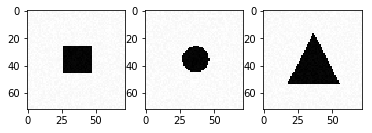

In [9]:
# Code de génération de formes

im_rect = generate_a_rectangle(10)
width = int(np.sqrt(im_rect.shape[0]))

plt.subplot(131); plt.imshow(im_rect.reshape(width, width), cmap='gray')
im_disk = generate_a_disk(10); plt.subplot(132); plt.imshow(im_disk.reshape(width, width), cmap='gray')
im_tri = generate_a_triangle(10)[0]; plt.subplot(133); plt.imshow(im_tri.reshape(width, width), cmap='gray')
plt.show()


We will then use them to create a dataset of 300 figures, each one containing a drawing, associated with a value y, depending on the form it contains : y=0 if it's a rectangle, y=1 if a disk and y=2 if a triangle.

In [10]:
[X_train, Y_train] = generate_dataset_classification(300, noise=20)


Creating dataset:   0%|          | 0/300 [00:00<?, ?it/s]

Creating dataset:   2%|▏         | 6/300 [00:00<00:05, 53.60it/s]

Creating dataset:   4%|▎         | 11/300 [00:00<00:05, 48.94it/s]

Creating dataset:   5%|▍         | 14/300 [00:00<00:07, 36.50it/s]

Creating dataset:   6%|▌         | 17/300 [00:00<00:15, 18.10it/s]

Creating dataset:   7%|▋         | 20/300 [00:00<00:13, 20.38it/s]

Creating dataset:   8%|▊         | 24/300 [00:00<00:12, 22.34it/s]

Creating dataset:   9%|▉         | 27/300 [00:01<00:13, 19.52it/s]

Creating dataset:  10%|█         | 31/300 [00:01<00:12, 22.33it/s]

Creating dataset:  11%|█▏        | 34/300 [00:01<00:11, 23.13it/s]

Creating dataset:  13%|█▎        | 38/300 [00:01<00:10, 25.86it/s]

Creating dataset:  14%|█▍        | 42/300 [00:01<00:09, 27.00it/s]

Creating dataset:  15%|█▌        | 46/300 [00:01<00:08, 28.58it/s]

Creating dataset:  17%|█▋        | 50/300 [00:02<00:18, 13.37it/s]

Creating dataset:  18%|█▊        | 54/300 [00:02<00:15, 16.32it/s]

Creating dataset:  20%|█▉        | 59/300 [00:02<00:11, 20.40it/s]

Creating dataset:  21%|██        | 63/300 [00:02<00:10, 21.81it/s]

Creating dataset:  23%|██▎       | 69/300 [00:02<00:08, 26.39it/s]

Creating dataset:  25%|██▍       | 74/300 [00:03<00:07, 30.03it/s]

Creating dataset:  26%|██▋       | 79/300 [00:03<00:06, 33.11it/s]

Creating dataset:  28%|██▊       | 84/300 [00:03<00:05, 36.44it/s]

Creating dataset:  30%|██▉       | 89/300 [00:03<00:05, 38.66it/s]

Creating dataset:  31%|███▏      | 94/300 [00:03<00:05, 40.39it/s]

Creating dataset:  33%|███▎      | 99/300 [00:03<00:04, 40.87it/s]

Creating dataset:  35%|███▍      | 104/300 [00:03<00:04, 42.58it/s]

Creating dataset:  36%|███▋      | 109/300 [00:03<00:06, 31.58it/s]

Creating dataset:  38%|███▊      | 113/300 [00:04<00:05, 33.54it/s]

Creating dataset:  39%|███▉      | 118/300 [00:04<00:05, 35.71it/s]

Creating dataset:  41%|████      | 122/300 [00:04<00:04, 36.20it/s]

Creating dataset:  42%|████▏     | 126/300 [00:04<00:05, 33.69it/s]

Creating dataset:  43%|████▎     | 130/300 [00:04<00:05, 33.76it/s]

Creating dataset:  45%|████▍     | 134/300 [00:04<00:04, 33.55it/s]

Creating dataset:  46%|████▌     | 138/300 [00:04<00:05, 31.00it/s]

Creating dataset:  48%|████▊     | 143/300 [00:04<00:04, 33.32it/s]

Creating dataset:  49%|████▉     | 147/300 [00:05<00:04, 34.90it/s]

Creating dataset:  51%|█████     | 152/300 [00:05<00:03, 37.02it/s]

Creating dataset:  52%|█████▏    | 157/300 [00:05<00:03, 38.93it/s]

Creating dataset:  54%|█████▎    | 161/300 [00:05<00:03, 38.68it/s]

Creating dataset:  55%|█████▌    | 165/300 [00:05<00:04, 28.24it/s]

Creating dataset:  56%|█████▋    | 169/300 [00:05<00:04, 30.34it/s]

Creating dataset:  58%|█████▊    | 175/300 [00:05<00:03, 34.34it/s]

Creating dataset:  60%|██████    | 180/300 [00:05<00:03, 36.58it/s]

Creating dataset:  62%|██████▏   | 185/300 [00:06<00:02, 38.50it/s]

Creating dataset:  64%|██████▎   | 191/300 [00:06<00:02, 40.85it/s]

Creating dataset:  65%|██████▌   | 196/300 [00:06<00:02, 41.51it/s]

Creating dataset:  67%|██████▋   | 201/300 [00:06<00:02, 42.52it/s]

Creating dataset:  69%|██████▊   | 206/300 [00:06<00:02, 38.46it/s]

Creating dataset:  70%|███████   | 211/300 [00:06<00:02, 36.37it/s]

Creating dataset:  72%|███████▏  | 216/300 [00:06<00:02, 38.79it/s]

Creating dataset:  74%|███████▎  | 221/300 [00:06<00:01, 41.28it/s]

Creating dataset:  75%|███████▌  | 226/300 [00:07<00:01, 42.68it/s]

Creating dataset:  77%|███████▋  | 231/300 [00:07<00:01, 43.94it/s]

Creating dataset:  79%|███████▊  | 236/300 [00:07<00:02, 31.48it/s]

Creating dataset:  80%|████████  | 241/300 [00:07<00:01, 35.20it/s]

Creating dataset:  82%|████████▏ | 246/300 [00:07<00:01, 38.02it/s]

Creating dataset:  84%|████████▎ | 251/300 [00:07<00:01, 40.67it/s]

Creating dataset:  86%|████████▌ | 257/300 [00:07<00:00, 44.13it/s]

Creating dataset:  88%|████████▊ | 263/300 [00:07<00:00, 46.39it/s]

Creating dataset:  89%|████████▉ | 268/300 [00:08<00:00, 46.89it/s]

Creating dataset:  91%|█████████▏| 274/300 [00:08<00:00, 49.32it/s]

Creating dataset:  93%|█████████▎| 280/300 [00:08<00:00, 47.87it/s]

Creating dataset:  95%|█████████▌| 286/300 [00:08<00:00, 49.09it/s]

Creating dataset:  97%|█████████▋| 292/300 [00:08<00:00, 49.86it/s]

Creating dataset:  99%|█████████▉| 298/300 [00:08<00:00, 50.93it/s]

Creating dataset: 100%|██████████| 300/300 [00:08<00:00, 34.42it/s]

Finally, we will create and train some two linear models on this data set: one using stochastic gradient descent optimizer, the other using Adam optimizer. Thus, well be abble to compare, on this example, the two optimizers.

Those models will take as inputs the images with reduces resolution, like it was done on the example with the written number reconizing given in class. This allow a limited number of inputs, which makes the convergence easier in our case with 300 training data.

****** SGD optimizer ******

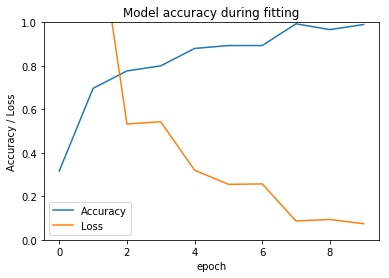

****** Adam optimizer ******

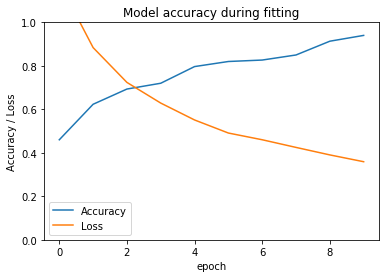

Prediction with sgd: rect: [[1. 0. 0.]] | disk: [[0. 1. 0.]] | triangle: [[0. 0. 1.]]

Prediction with Adam: rect: [[1. 0. 0.]] | disk: [[1.0000000e+00 6.7181197e-22 0.0000000e+00]] | triangle: [[0. 0. 1.]]

In [11]:
model_sgd, history_sgd = linear_model(X_train, Y_train, 'sgd', verbose=False)
model_adam, history_adam = linear_model(X_train, Y_train, 'adam', verbose=False)

print('****** SGD optimizer ******')
plot_history(history_sgd)
print('****** Adam optimizer ******')
plot_history(history_adam)

X_rec = generate_a_rectangle(10); X_rec = X_rec.reshape(1, width, width); X_rec = X_rec[::, ::2, ::2]
X_disk = generate_a_disk(10); X_disk = X_disk.reshape(1, width, width); X_disk = X_disk[::, ::2, ::2]
X_tri = generate_a_triangle(10)[0]; X_tri = X_tri.reshape(1, width, width); X_tri = X_tri[::, ::2, ::2]

print('Prediction with sgd: rect: %s | disk: %s | triangle: %s' % 
      (model_sgd.predict(X_rec), model_sgd.predict(X_disk), model_sgd.predict(X_tri)))

print('Prediction with Adam: rect: %s | disk: %s | triangle: %s' % 
      (model_adam.predict(X_rec), model_adam.predict(X_disk), model_adam.predict(X_tri)))


On this example, the Adam is converging less efficently than the SGD optimizer. From one prediction to another, sometimes the prediction is not the right one. With 10 epochs, on the test I just launched (thos evalue can change from one dataset to another), the SGD optimizer end with an accuracy of 0.9667, while the Adam with an accuracy of only 0.8700.

Nevertheless, this one could be enhanced easily with more rounds of optimizing (epochs), but in this example, we wanted to see what would happen with a little number of epochs. The next state does the same optimisation, but with an increased number of epochs :

****** Adam optimizer ******

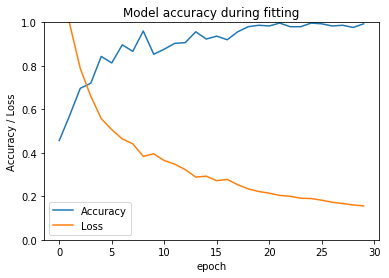

In [12]:
print('****** Adam optimizer ******')
model_adam, history_adam = linear_model(X_train, Y_train, 'adam', epochs=30, verbose=False)

plot_history(history_adam)

### 4 Visualization of the solution

Now that our linear network is working, we will look at the values of the weights applied inside it. Those paramters are simply the ones of the vector A such that $Y_i=A_i^T*X$. Thus, each vector $A_i$ has the same size of the pictures given as inputs, we can then show them like images, which is done just after :

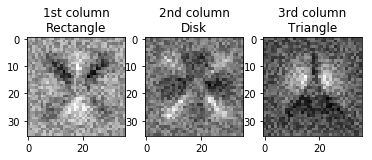

In [13]:
weights = model_sgd.get_weights()
width_w = int(np.sqrt(weights[0][::,0].shape))

plt.subplot(131); plt.imshow(weights[0][::,0].reshape(width_w, width_w), cmap='gray'); plt.title('1st column\nRectangle')
plt.subplot(132); plt.imshow(weights[0][::,1].reshape(width_w, width_w), cmap='gray'); plt.title('2nd column\nDisk')
plt.subplot(133); plt.imshow(weights[0][::,2].reshape(width_w, width_w), cmap='gray'); plt.title('3rd column\nTriangle')
plt.show()


We can see on those images what pixels of the image are used to determine the shape of the drawing. For exemple, for the circles, mainly the diagonals seems to count, while on the triangle, it would be the pixels over the two inclined edges of the triangle, which are inside of the other shapes, but out of the triangle for example.

###5 A more difficult classification problem

Now, the shapes are allowed to move within the images and change dimensions. Thus, we will need a much more robust neuronal network

Creating dataset:   0%|          | 0/300 [00:00<?, ?it/s]

Creating dataset:   2%|▏         | 6/300 [00:00<00:05, 52.67it/s]

Creating dataset:   3%|▎         | 9/300 [00:00<00:07, 40.03it/s]

Creating dataset:   4%|▍         | 12/300 [00:00<00:08, 32.81it/s]

Creating dataset:   5%|▌         | 15/300 [00:00<00:09, 31.61it/s]

Creating dataset:   6%|▋         | 19/300 [00:00<00:08, 31.44it/s]

Creating dataset:   7%|▋         | 22/300 [00:00<00:09, 28.93it/s]

Creating dataset:   9%|▊         | 26/300 [00:00<00:09, 30.41it/s]

Creating dataset:  10%|█         | 30/300 [00:00<00:08, 31.31it/s]

Creating dataset:  11%|█         | 33/300 [00:01<00:09, 29.37it/s]

Creating dataset:  12%|█▏        | 36/300 [00:01<00:09, 27.15it/s]

Creating dataset:  13%|█▎        | 39/300 [00:01<00:12, 20.67it/s]

Creating dataset:  14%|█▍        | 42/300 [00:01<00:15, 17.05it/s]

Creating dataset:  16%|█▌        | 47/300 [00:01<00:11, 21.09it/s]

Creating dataset:  17%|█▋        | 52/300 [00:01<00:09, 24.88it/s]

Creating dataset:  19%|█▉        | 58/300 [00:02<00:08, 29.77it/s]

Creating dataset:  21%|██▏       | 64/300 [00:02<00:06, 34.12it/s]

Creating dataset:  23%|██▎       | 70/300 [00:02<00:05, 38.89it/s]

Creating dataset:  25%|██▌       | 75/300 [00:02<00:05, 41.36it/s]

Creating dataset:  27%|██▋       | 80/300 [00:02<00:05, 41.46it/s]

Creating dataset:  28%|██▊       | 85/300 [00:02<00:04, 43.37it/s]

Creating dataset:  30%|███       | 90/300 [00:02<00:04, 44.10it/s]

Creating dataset:  32%|███▏      | 95/300 [00:02<00:05, 34.47it/s]

Creating dataset:  33%|███▎      | 100/300 [00:02<00:05, 37.68it/s]

Creating dataset:  35%|███▌      | 105/300 [00:03<00:04, 39.07it/s]

Creating dataset:  37%|███▋      | 112/300 [00:03<00:04, 43.94it/s]

Creating dataset:  39%|███▉      | 117/300 [00:03<00:04, 43.93it/s]

Creating dataset:  41%|████      | 122/300 [00:03<00:04, 44.38it/s]

Creating dataset:  42%|████▏     | 127/300 [00:03<00:03, 44.00it/s]

Creating dataset:  44%|████▍     | 133/300 [00:03<00:03, 46.17it/s]

Creating dataset:  46%|████▌     | 138/300 [00:03<00:03, 47.13it/s]

Creating dataset:  48%|████▊     | 143/300 [00:03<00:03, 47.83it/s]

Creating dataset:  50%|████▉     | 149/300 [00:03<00:03, 48.70it/s]

Creating dataset:  52%|█████▏    | 155/300 [00:04<00:02, 50.33it/s]

Creating dataset:  54%|█████▎    | 161/300 [00:04<00:03, 36.97it/s]

Creating dataset:  56%|█████▌    | 167/300 [00:04<00:03, 40.27it/s]

Creating dataset:  57%|█████▋    | 172/300 [00:04<00:03, 42.12it/s]

Creating dataset:  59%|█████▉    | 177/300 [00:04<00:02, 42.53it/s]

Creating dataset:  61%|██████▏   | 184/300 [00:04<00:02, 46.86it/s]

Creating dataset:  64%|██████▍   | 192/300 [00:04<00:02, 52.46it/s]

Creating dataset:  67%|██████▋   | 200/300 [00:05<00:01, 57.50it/s]

Creating dataset:  69%|██████▉   | 208/300 [00:05<00:01, 61.65it/s]

Creating dataset:  72%|███████▏  | 216/300 [00:05<00:01, 64.92it/s]

Creating dataset:  74%|███████▍  | 223/300 [00:05<00:01, 60.37it/s]

Creating dataset:  77%|███████▋  | 230/300 [00:05<00:01, 56.84it/s]

Creating dataset:  79%|███████▉  | 237/300 [00:05<00:01, 43.52it/s]

Creating dataset:  81%|████████▏ | 244/300 [00:05<00:01, 48.18it/s]

Creating dataset:  84%|████████▍ | 252/300 [00:05<00:00, 53.40it/s]

Creating dataset:  87%|████████▋ | 260/300 [00:06<00:00, 57.91it/s]

Creating dataset:  89%|████████▉ | 267/300 [00:06<00:00, 60.14it/s]

Creating dataset:  92%|█████████▏| 275/300 [00:06<00:00, 63.59it/s]

Creating dataset:  94%|█████████▍| 283/300 [00:06<00:00, 65.93it/s]

Creating dataset:  97%|█████████▋| 291/300 [00:06<00:00, 67.67it/s]

Creating dataset: 100%|█████████▉| 299/300 [00:06<00:00, 69.31it/s]

Creating dataset: 100%|██████████| 300/300 [00:06<00:00, 45.00it/s]

Creating dataset:   0%|          | 0/300 [00:00<?, ?it/s]

Creating dataset:   2%|▏         | 7/300 [00:00<00:04, 67.35it/s]

Creating dataset:   5%|▌         | 15/300 [00:00<00:04, 69.42it/s]

Creating dataset:   7%|▋         | 22/300 [00:00<00:06, 43.53it/s]

Creating dataset:  10%|█         | 30/300 [00:00<00:05, 49.77it/s]

Creating dataset:  13%|█▎        | 38/300 [00:00<00:04, 54.98it/s]

Creating dataset:  15%|█▌        | 46/300 [00:00<00:04, 59.33it/s]

Creating dataset:  18%|█▊        | 54/300 [00:00<00:03, 63.11it/s]

Creating dataset:  21%|██        | 62/300 [00:01<00:03, 66.05it/s]

Creating dataset:  23%|██▎       | 70/300 [00:01<00:03, 67.42it/s]

Creating dataset:  26%|██▌       | 78/300 [00:01<00:03, 69.12it/s]

Creating dataset:  28%|██▊       | 85/300 [00:01<00:03, 68.98it/s]

Creating dataset:  31%|███       | 93/300 [00:01<00:02, 69.53it/s]

Creating dataset:  34%|███▎      | 101/300 [00:01<00:02, 70.84it/s]

Creating dataset:  36%|███▋      | 109/300 [00:01<00:02, 71.60it/s]

Creating dataset:  39%|███▉      | 117/300 [00:01<00:02, 71.95it/s]

Creating dataset:  42%|████▏     | 125/300 [00:01<00:02, 65.30it/s]

Creating dataset:  44%|████▍     | 132/300 [00:02<00:02, 62.22it/s]

Creating dataset:  46%|████▋     | 139/300 [00:02<00:02, 60.38it/s]

Creating dataset:  49%|████▊     | 146/300 [00:02<00:02, 61.98it/s]

Creating dataset:  51%|█████     | 153/300 [00:02<00:03, 37.49it/s]

Creating dataset:  54%|█████▎    | 161/300 [00:02<00:03, 44.02it/s]

Creating dataset:  56%|█████▋    | 169/300 [00:02<00:02, 49.85it/s]

Creating dataset:  59%|█████▊    | 176/300 [00:03<00:02, 54.44it/s]

Creating dataset:  61%|██████    | 183/300 [00:03<00:02, 58.19it/s]

Creating dataset:  63%|██████▎   | 190/300 [00:03<00:01, 60.98it/s]

Creating dataset:  66%|██████▌   | 198/300 [00:03<00:01, 64.25it/s]

Creating dataset:  69%|██████▊   | 206/300 [00:03<00:01, 66.59it/s]

Creating dataset:  71%|███████   | 213/300 [00:03<00:01, 65.32it/s]

Creating dataset:  74%|███████▎  | 221/300 [00:03<00:01, 67.72it/s]

Creating dataset:  76%|███████▋  | 229/300 [00:03<00:01, 69.33it/s]

Creating dataset:  79%|███████▉  | 237/300 [00:03<00:00, 70.33it/s]

Creating dataset:  82%|████████▏ | 245/300 [00:03<00:00, 71.43it/s]

Creating dataset:  84%|████████▍ | 253/300 [00:04<00:00, 70.31it/s]

Creating dataset:  87%|████████▋ | 261/300 [00:04<00:00, 68.12it/s]

Creating dataset:  90%|████████▉ | 269/300 [00:04<00:00, 69.28it/s]

Creating dataset:  92%|█████████▏| 276/300 [00:04<00:00, 69.30it/s]

Creating dataset:  95%|█████████▍| 284/300 [00:04<00:00, 69.93it/s]

Creating dataset:  97%|█████████▋| 292/300 [00:04<00:00, 70.39it/s]

Creating dataset: 100%|██████████| 300/300 [00:04<00:00, 70.90it/s]

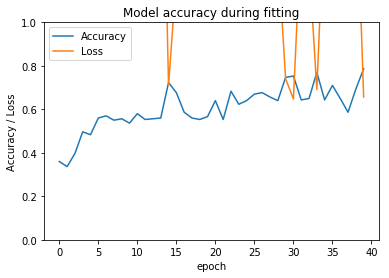

***** Results on the test dataset *****

Loss: 1.7915109165509542 | Accuracy: 0.59

In [14]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
model_lin, history_lin = linear_model(X_train, Y_train, epochs=40, verbose=False)

[X_test, Y_test] = generate_test_set_classification()
width = int(np.sqrt(X_test[0].shape[0]))
X_test = X_test.reshape(X_test.shape[0], width, width)
X_test = X_test[::, ::2, ::2]

plot_history(history_lin)
print('***** Results on the test dataset *****')
evaluation = model_lin.evaluate(X_test, Y_test, verbose=False)
print('Loss: %s | Accuracy: %s' % (evaluation[0], evaluation[1]))


The previously used linear model achieves really low scores on this new task.

We will then use a new deep network to complete this task, composed of 1 convolutional layer with 16 5×5 filters, 1 pooling layer, and one fully connected layer.

Creating dataset:   0%|          | 0/500 [00:00<?, ?it/s]

Creating dataset:   1%|▏         | 7/500 [00:00<00:07, 69.35it/s]

Creating dataset:   3%|▎         | 14/500 [00:00<00:07, 68.93it/s]

Creating dataset:   4%|▍         | 21/500 [00:00<00:07, 65.39it/s]

Creating dataset:   5%|▌         | 26/500 [00:00<00:08, 54.23it/s]

Creating dataset:   6%|▋         | 32/500 [00:00<00:08, 55.08it/s]

Creating dataset:   7%|▋         | 37/500 [00:00<00:09, 48.49it/s]

Creating dataset:   8%|▊         | 42/500 [00:00<00:09, 48.23it/s]

Creating dataset:   9%|▉         | 47/500 [00:01<00:16, 27.07it/s]

Creating dataset:  10%|█         | 51/500 [00:01<00:18, 24.52it/s]

Creating dataset:  11%|█         | 56/500 [00:01<00:15, 28.03it/s]

Creating dataset:  12%|█▏        | 62/500 [00:01<00:13, 32.44it/s]

Creating dataset:  14%|█▎        | 68/500 [00:01<00:11, 37.14it/s]

Creating dataset:  15%|█▍        | 74/500 [00:01<00:10, 40.83it/s]

Creating dataset:  16%|█▌        | 80/500 [00:01<00:09, 44.17it/s]

Creating dataset:  17%|█▋        | 86/500 [00:02<00:08, 46.41it/s]

Creating dataset:  18%|█▊        | 92/500 [00:02<00:08, 46.67it/s]

Creating dataset:  20%|█▉        | 98/500 [00:02<00:08, 47.40it/s]

Creating dataset:  21%|██        | 103/500 [00:02<00:11, 35.92it/s]

Creating dataset:  22%|██▏       | 108/500 [00:02<00:10, 38.60it/s]

Creating dataset:  23%|██▎       | 114/500 [00:02<00:09, 42.41it/s]

Creating dataset:  24%|██▍       | 119/500 [00:02<00:08, 44.32it/s]

Creating dataset:  25%|██▍       | 124/500 [00:02<00:08, 43.61it/s]

Creating dataset:  26%|██▌       | 129/500 [00:03<00:08, 44.63it/s]

Creating dataset:  27%|██▋       | 135/500 [00:03<00:07, 47.21it/s]

Creating dataset:  28%|██▊       | 141/500 [00:03<00:07, 49.32it/s]

Creating dataset:  29%|██▉       | 147/500 [00:03<00:07, 50.03it/s]

Creating dataset:  31%|███       | 153/500 [00:03<00:06, 51.05it/s]

Creating dataset:  32%|███▏      | 159/500 [00:03<00:06, 52.20it/s]

Creating dataset:  33%|███▎      | 165/500 [00:03<00:06, 54.03it/s]

Creating dataset:  34%|███▍      | 171/500 [00:03<00:08, 37.95it/s]

Creating dataset:  35%|███▌      | 177/500 [00:04<00:07, 42.12it/s]

Creating dataset:  37%|███▋      | 183/500 [00:04<00:06, 45.42it/s]

Creating dataset:  38%|███▊      | 189/500 [00:04<00:06, 47.83it/s]

Creating dataset:  39%|███▉      | 195/500 [00:04<00:06, 49.80it/s]

Creating dataset:  40%|████      | 201/500 [00:04<00:06, 49.49it/s]

Creating dataset:  41%|████▏     | 207/500 [00:04<00:05, 50.53it/s]

Creating dataset:  43%|████▎     | 213/500 [00:04<00:05, 49.26it/s]

Creating dataset:  44%|████▍     | 219/500 [00:04<00:05, 49.86it/s]

Creating dataset:  45%|████▌     | 225/500 [00:04<00:05, 52.39it/s]

Creating dataset:  46%|████▋     | 232/500 [00:05<00:04, 54.31it/s]

Creating dataset:  48%|████▊     | 238/500 [00:05<00:05, 49.91it/s]

Creating dataset:  49%|████▉     | 244/500 [00:05<00:05, 49.21it/s]

Creating dataset:  50%|█████     | 250/500 [00:05<00:05, 49.57it/s]

Creating dataset:  51%|█████     | 256/500 [00:05<00:04, 49.59it/s]

Creating dataset:  52%|█████▏    | 262/500 [00:05<00:06, 34.53it/s]

Creating dataset:  54%|█████▍    | 270/500 [00:06<00:05, 41.18it/s]

Creating dataset:  56%|█████▌    | 278/500 [00:06<00:04, 47.52it/s]

Creating dataset:  57%|█████▋    | 286/500 [00:06<00:04, 52.83it/s]

Creating dataset:  59%|█████▉    | 294/500 [00:06<00:03, 58.06it/s]

Creating dataset:  60%|██████    | 302/500 [00:06<00:03, 61.81it/s]

Creating dataset:  62%|██████▏   | 310/500 [00:06<00:02, 64.58it/s]

Creating dataset:  63%|██████▎   | 317/500 [00:06<00:02, 65.94it/s]

Creating dataset:  65%|██████▍   | 324/500 [00:06<00:02, 62.29it/s]

Creating dataset:  66%|██████▋   | 332/500 [00:06<00:02, 64.94it/s]

Creating dataset:  68%|██████▊   | 340/500 [00:07<00:02, 67.10it/s]

Creating dataset:  70%|██████▉   | 348/500 [00:07<00:02, 68.71it/s]

Creating dataset:  71%|███████   | 356/500 [00:07<00:02, 69.88it/s]

Creating dataset:  73%|███████▎  | 364/500 [00:07<00:01, 70.35it/s]

Creating dataset:  74%|███████▍  | 372/500 [00:07<00:02, 43.78it/s]

Creating dataset:  76%|███████▌  | 380/500 [00:07<00:02, 49.72it/s]

Creating dataset:  78%|███████▊  | 388/500 [00:07<00:02, 55.17it/s]

Creating dataset:  79%|███████▉  | 396/500 [00:08<00:01, 59.48it/s]

Creating dataset:  81%|████████  | 403/500 [00:08<00:01, 62.13it/s]

Creating dataset:  82%|████████▏ | 411/500 [00:08<00:01, 65.14it/s]

Creating dataset:  84%|████████▍ | 419/500 [00:08<00:01, 67.09it/s]

Creating dataset:  85%|████████▌ | 427/500 [00:08<00:01, 68.87it/s]

Creating dataset:  87%|████████▋ | 435/500 [00:08<00:00, 70.00it/s]

Creating dataset:  89%|████████▊ | 443/500 [00:08<00:00, 70.81it/s]

Creating dataset:  90%|█████████ | 451/500 [00:08<00:00, 71.58it/s]

Creating dataset:  92%|█████████▏| 459/500 [00:08<00:00, 71.93it/s]

Creating dataset:  93%|█████████▎| 467/500 [00:09<00:00, 72.29it/s]

Creating dataset:  95%|█████████▌| 475/500 [00:09<00:00, 72.44it/s]

Creating dataset:  97%|█████████▋| 483/500 [00:09<00:00, 72.93it/s]

Creating dataset:  98%|█████████▊| 491/500 [00:09<00:00, 72.68it/s]

Creating dataset: 100%|█████████▉| 499/500 [00:09<00:00, 72.91it/s]

Creating dataset: 100%|██████████| 500/500 [00:09<00:00, 52.86it/s]

Creating dataset:   0%|          | 0/300 [00:00<?, ?it/s]

Creating dataset:   3%|▎         | 8/300 [00:00<00:03, 74.81it/s]

Creating dataset:   5%|▌         | 16/300 [00:00<00:03, 74.18it/s]

Creating dataset:   8%|▊         | 24/300 [00:00<00:03, 74.58it/s]

Creating dataset:  11%|█         | 32/300 [00:00<00:03, 74.23it/s]

Creating dataset:  13%|█▎        | 40/300 [00:00<00:03, 74.61it/s]

Creating dataset:  16%|█▌        | 48/300 [00:00<00:03, 74.67it/s]

Creating dataset:  19%|█▊        | 56/300 [00:00<00:03, 74.30it/s]

Creating dataset:  21%|██▏       | 64/300 [00:00<00:03, 73.83it/s]

Creating dataset:  24%|██▎       | 71/300 [00:00<00:03, 72.20it/s]

Creating dataset:  26%|██▋       | 79/300 [00:01<00:03, 72.57it/s]

Creating dataset:  29%|██▉       | 87/300 [00:01<00:02, 73.03it/s]

Creating dataset:  32%|███▏      | 95/300 [00:01<00:02, 73.15it/s]

Creating dataset:  34%|███▍      | 103/300 [00:01<00:02, 66.31it/s]

Creating dataset:  37%|███▋      | 111/300 [00:01<00:02, 68.31it/s]

Creating dataset:  40%|███▉      | 119/300 [00:01<00:02, 70.13it/s]

Creating dataset:  42%|████▏     | 127/300 [00:01<00:02, 71.09it/s]

Creating dataset:  45%|████▌     | 135/300 [00:01<00:02, 71.59it/s]

Creating dataset:  48%|████▊     | 143/300 [00:01<00:02, 72.13it/s]

Creating dataset:  50%|█████     | 151/300 [00:02<00:04, 33.69it/s]

Creating dataset:  53%|█████▎    | 159/300 [00:02<00:03, 40.28it/s]

Creating dataset:  55%|█████▌    | 166/300 [00:02<00:03, 43.18it/s]

Creating dataset:  58%|█████▊    | 173/300 [00:02<00:02, 48.49it/s]

Creating dataset:  60%|██████    | 180/300 [00:02<00:02, 51.53it/s]

Creating dataset:  62%|██████▏   | 187/300 [00:03<00:02, 51.52it/s]

Creating dataset:  64%|██████▍   | 193/300 [00:03<00:02, 52.26it/s]

Creating dataset:  67%|██████▋   | 200/300 [00:03<00:01, 55.24it/s]

Creating dataset:  69%|██████▊   | 206/300 [00:03<00:01, 56.43it/s]

Creating dataset:  71%|███████   | 213/300 [00:03<00:01, 57.85it/s]

Creating dataset:  73%|███████▎  | 219/300 [00:03<00:01, 57.48it/s]

Creating dataset:  75%|███████▌  | 225/300 [00:03<00:01, 56.74it/s]

Creating dataset:  77%|███████▋  | 232/300 [00:03<00:01, 57.93it/s]

Creating dataset:  79%|███████▉  | 238/300 [00:03<00:01, 58.03it/s]

Creating dataset:  81%|████████▏ | 244/300 [00:04<00:00, 57.11it/s]

Creating dataset:  84%|████████▎ | 251/300 [00:04<00:00, 59.23it/s]

Creating dataset:  86%|████████▋ | 259/300 [00:04<00:00, 62.88it/s]

Creating dataset:  89%|████████▉ | 267/300 [00:04<00:00, 65.88it/s]

Creating dataset:  91%|█████████▏| 274/300 [00:04<00:00, 62.25it/s]

Creating dataset:  94%|█████████▎| 281/300 [00:04<00:00, 60.24it/s]

Creating dataset:  96%|█████████▋| 289/300 [00:04<00:00, 63.52it/s]

Creating dataset:  99%|█████████▉| 297/300 [00:04<00:00, 65.87it/s]

Creating dataset: 100%|██████████| 300/300 [00:04<00:00, 60.80it/s]

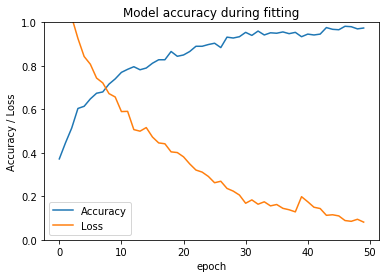

***** Results on the test dataset *****

Loss: 0.7902231506506602 | Accuracy: 0.7533333325386047

In [15]:
[X_train, Y_train] = generate_dataset_classification(500, 20, True)
model_conv, history_conv = convolutionnal_model(X_train, Y_train, 'sgd', epochs=50, verbose=False)

[X_test, Y_test] = generate_test_set_classification()
X_test = adapt_dataset(X_test)
X_test = X_test.reshape(X_test.shape + (1,))

plot_history(history_conv)
print('***** Results on the test dataset *****')
evaluation = model_conv.evaluate(X_test, Y_test, verbose=False)
print('Loss: %s | Accuracy: %s' % (evaluation[0], evaluation[1]))


This new model presents much better results : it obtain an accuracy of almost 1 on the training dataset, and a 83% accuracy on the test dataset, when the training one was of 500 samples.

### 6. A regression problem

In this part, I tried to create a regression network to predict the positions of the 3 corners of a triangle.

Firstly, I had to 'normalize' the outputs of the dataset: indeed, the coordinates of the points were random numbers between 0 and 1, thus the 3 edges were not sorted, and there were thus, for each picture, 3 possible answers, depending on the sorting order of the points. Hence, the first step was to sort those three points in a 'logical' way. To do that, I decided to sort them in growing order of their norms. This was the last solution I tried, though I tried other solutions before, as can be seen in the code (e.g. the first point was the higher one, and the two others were sorted in trigonomic order).

Then, this dataset was sent in a regression network made of 4 Convolution-MaxPooling and two Dense layers. Unfortunately, with the best learning rate possible, this solution stayed at an accuracy of only 0.4, without growing. Many other configurations had been tested before, and this one is the one with the best 'theorical' results. In fact, if 'theorically', the accuracy is about 0.4, on the test dataset, the results are aberrant, the model predicting coordinates higher than $10e4$ while the results should be between 0 and 1.

In conclusion, I unfortunately failed to implement this regression task, despite a huge number of tries.

Creating dataset:   0%|          | 0/1000 [00:00<?, ?it/s]

Creating dataset:   0%|          | 4/1000 [00:00<00:29, 34.21it/s]

Creating dataset:   1%|          | 9/1000 [00:00<00:26, 37.62it/s]

Creating dataset:   2%|▏         | 15/1000 [00:00<00:23, 42.28it/s]

Creating dataset:   2%|▏         | 19/1000 [00:00<00:25, 38.79it/s]

Creating dataset:   2%|▏         | 24/1000 [00:00<00:24, 40.58it/s]

Creating dataset:   3%|▎         | 29/1000 [00:00<00:22, 42.69it/s]

Creating dataset:   3%|▎         | 34/1000 [00:00<00:22, 42.93it/s]

Creating dataset:   4%|▍         | 39/1000 [00:00<00:21, 44.72it/s]

Creating dataset:   4%|▍         | 45/1000 [00:00<00:20, 46.08it/s]

Creating dataset:   5%|▌         | 51/1000 [00:01<00:19, 48.34it/s]

Creating dataset:   6%|▌         | 57/1000 [00:01<00:18, 50.18it/s]

Creating dataset:   6%|▋         | 63/1000 [00:01<00:17, 52.50it/s]

Creating dataset:   7%|▋         | 69/1000 [00:02<00:54, 16.99it/s]

Creating dataset:   7%|▋         | 73/1000 [00:02<00:45, 20.41it/s]

Creating dataset:   8%|▊         | 78/1000 [00:02<00:38, 24.17it/s]

Creating dataset:   8%|▊         | 82/1000 [00:02<00:33, 27.10it/s]

Creating dataset:   9%|▊         | 86/1000 [00:03<01:00, 15.17it/s]

Creating dataset:   9%|▉         | 91/1000 [00:03<00:47, 19.11it/s]

Creating dataset:  10%|▉         | 96/1000 [00:03<00:38, 23.39it/s]

Creating dataset:  10%|█         | 103/1000 [00:03<00:30, 28.98it/s]

Creating dataset:  11%|█         | 108/1000 [00:03<00:26, 33.10it/s]

Creating dataset:  11%|█▏        | 114/1000 [00:03<00:23, 38.10it/s]

Creating dataset:  12%|█▏        | 120/1000 [00:03<00:21, 40.37it/s]

Creating dataset:  13%|█▎        | 126/1000 [00:03<00:20, 43.70it/s]

Creating dataset:  13%|█▎        | 132/1000 [00:03<00:18, 45.84it/s]

Creating dataset:  14%|█▍        | 138/1000 [00:04<00:18, 46.36it/s]

Creating dataset:  14%|█▍        | 144/1000 [00:04<00:18, 47.07it/s]

Creating dataset:  15%|█▌        | 150/1000 [00:04<00:17, 48.27it/s]

Creating dataset:  16%|█▌        | 156/1000 [00:04<00:17, 49.51it/s]

Creating dataset:  16%|█▋        | 163/1000 [00:04<00:15, 52.57it/s]

Creating dataset:  17%|█▋        | 169/1000 [00:04<00:23, 35.08it/s]

Creating dataset:  17%|█▋        | 174/1000 [00:04<00:21, 38.18it/s]

Creating dataset:  18%|█▊        | 179/1000 [00:05<00:20, 40.11it/s]

Creating dataset:  18%|█▊        | 185/1000 [00:05<00:18, 43.48it/s]

Creating dataset:  19%|█▉        | 191/1000 [00:05<00:18, 44.75it/s]

Creating dataset:  20%|█▉        | 196/1000 [00:05<00:18, 42.56it/s]

Creating dataset:  20%|██        | 201/1000 [00:05<00:18, 42.62it/s]

Creating dataset:  21%|██        | 206/1000 [00:05<00:17, 44.13it/s]

Creating dataset:  21%|██        | 211/1000 [00:05<00:18, 42.92it/s]

Creating dataset:  22%|██▏       | 217/1000 [00:05<00:17, 45.55it/s]

Creating dataset:  22%|██▏       | 222/1000 [00:06<00:18, 42.40it/s]

Creating dataset:  23%|██▎       | 227/1000 [00:06<00:18, 42.40it/s]

Creating dataset:  23%|██▎       | 232/1000 [00:06<00:18, 41.66it/s]

Creating dataset:  24%|██▎       | 237/1000 [00:06<00:17, 43.18it/s]

Creating dataset:  24%|██▍       | 244/1000 [00:06<00:15, 47.31it/s]

Creating dataset:  25%|██▍       | 249/1000 [00:06<00:15, 47.82it/s]

Creating dataset:  26%|██▌       | 255/1000 [00:06<00:15, 48.23it/s]

Creating dataset:  26%|██▌       | 260/1000 [00:06<00:16, 43.65it/s]

Creating dataset:  26%|██▋       | 265/1000 [00:07<00:24, 29.86it/s]

Creating dataset:  27%|██▋       | 269/1000 [00:07<00:22, 31.94it/s]

Creating dataset:  28%|██▊       | 276/1000 [00:07<00:19, 36.67it/s]

Creating dataset:  28%|██▊       | 283/1000 [00:07<00:17, 41.79it/s]

Creating dataset:  29%|██▉       | 291/1000 [00:07<00:14, 47.99it/s]

Creating dataset:  30%|██▉       | 299/1000 [00:07<00:13, 53.45it/s]

Creating dataset:  31%|███       | 306/1000 [00:07<00:12, 57.12it/s]

Creating dataset:  31%|███▏      | 313/1000 [00:07<00:12, 54.53it/s]

Creating dataset:  32%|███▏      | 319/1000 [00:08<00:14, 46.88it/s]

Creating dataset:  32%|███▎      | 325/1000 [00:08<00:15, 44.59it/s]

Creating dataset:  33%|███▎      | 330/1000 [00:08<00:15, 42.67it/s]

Creating dataset:  34%|███▎      | 336/1000 [00:08<00:14, 45.66it/s]

Creating dataset:  34%|███▍      | 344/1000 [00:08<00:12, 51.11it/s]

Creating dataset:  35%|███▌      | 352/1000 [00:08<00:11, 56.24it/s]

Creating dataset:  36%|███▌      | 360/1000 [00:08<00:10, 60.21it/s]

Creating dataset:  37%|███▋      | 367/1000 [00:08<00:10, 61.54it/s]

Creating dataset:  37%|███▋      | 374/1000 [00:09<00:10, 62.16it/s]

Creating dataset:  38%|███▊      | 382/1000 [00:09<00:09, 64.85it/s]

Creating dataset:  39%|███▉      | 389/1000 [00:09<00:18, 33.35it/s]

Creating dataset:  40%|███▉      | 395/1000 [00:09<00:15, 38.26it/s]

Creating dataset:  40%|████      | 401/1000 [00:09<00:14, 41.25it/s]

Creating dataset:  41%|████      | 408/1000 [00:09<00:12, 46.03it/s]

Creating dataset:  42%|████▏     | 415/1000 [00:10<00:11, 51.20it/s]

Creating dataset:  42%|████▏     | 423/1000 [00:10<00:10, 56.31it/s]

Creating dataset:  43%|████▎     | 431/1000 [00:10<00:09, 60.69it/s]

Creating dataset:  44%|████▍     | 439/1000 [00:10<00:08, 64.48it/s]

Creating dataset:  45%|████▍     | 447/1000 [00:10<00:08, 67.10it/s]

Creating dataset:  46%|████▌     | 455/1000 [00:10<00:07, 68.88it/s]

Creating dataset:  46%|████▋     | 463/1000 [00:10<00:07, 69.82it/s]

Creating dataset:  47%|████▋     | 471/1000 [00:10<00:08, 65.47it/s]

Creating dataset:  48%|████▊     | 479/1000 [00:10<00:07, 68.20it/s]

Creating dataset:  49%|████▊     | 487/1000 [00:11<00:07, 69.51it/s]

Creating dataset:  50%|████▉     | 495/1000 [00:11<00:07, 71.02it/s]

Creating dataset:  50%|█████     | 503/1000 [00:11<00:06, 71.92it/s]

Creating dataset:  51%|█████     | 511/1000 [00:11<00:06, 72.57it/s]

Creating dataset:  52%|█████▏    | 519/1000 [00:11<00:06, 73.43it/s]

Creating dataset:  53%|█████▎    | 527/1000 [00:11<00:06, 73.84it/s]

Creating dataset:  54%|█████▎    | 535/1000 [00:11<00:06, 70.59it/s]

Creating dataset:  54%|█████▍    | 543/1000 [00:12<00:12, 37.92it/s]

Creating dataset:  55%|█████▌    | 550/1000 [00:12<00:10, 43.16it/s]

Creating dataset:  56%|█████▌    | 558/1000 [00:12<00:08, 49.34it/s]

Creating dataset:  57%|█████▋    | 566/1000 [00:12<00:07, 54.73it/s]

Creating dataset:  57%|█████▋    | 574/1000 [00:12<00:07, 59.66it/s]

Creating dataset:  58%|█████▊    | 582/1000 [00:12<00:06, 63.07it/s]

Creating dataset:  59%|█████▉    | 590/1000 [00:12<00:06, 65.86it/s]

Creating dataset:  60%|█████▉    | 598/1000 [00:12<00:05, 68.13it/s]

Creating dataset:  61%|██████    | 606/1000 [00:13<00:05, 70.00it/s]

Creating dataset:  61%|██████▏   | 614/1000 [00:13<00:05, 70.44it/s]

Creating dataset:  62%|██████▏   | 622/1000 [00:13<00:05, 71.69it/s]

Creating dataset:  63%|██████▎   | 630/1000 [00:13<00:05, 72.60it/s]

Creating dataset:  64%|██████▍   | 638/1000 [00:13<00:04, 73.25it/s]

Creating dataset:  65%|██████▍   | 646/1000 [00:13<00:04, 73.92it/s]

Creating dataset:  65%|██████▌   | 654/1000 [00:13<00:04, 73.98it/s]

Creating dataset:  66%|██████▌   | 662/1000 [00:13<00:04, 74.02it/s]

Creating dataset:  67%|██████▋   | 670/1000 [00:13<00:04, 74.25it/s]

Creating dataset:  68%|██████▊   | 678/1000 [00:13<00:04, 73.59it/s]

Creating dataset:  69%|██████▊   | 686/1000 [00:14<00:04, 72.35it/s]

Creating dataset:  69%|██████▉   | 694/1000 [00:14<00:04, 72.87it/s]

Creating dataset:  70%|███████   | 702/1000 [00:14<00:04, 72.84it/s]

Creating dataset:  71%|███████   | 710/1000 [00:14<00:03, 73.42it/s]

Creating dataset:  72%|███████▏  | 718/1000 [00:14<00:03, 73.42it/s]

Creating dataset:  73%|███████▎  | 726/1000 [00:14<00:03, 73.63it/s]

Creating dataset:  73%|███████▎  | 734/1000 [00:14<00:03, 73.57it/s]

Creating dataset:  74%|███████▍  | 742/1000 [00:15<00:07, 33.53it/s]

Creating dataset:  75%|███████▌  | 750/1000 [00:15<00:06, 40.00it/s]

Creating dataset:  76%|███████▌  | 758/1000 [00:15<00:05, 46.33it/s]

Creating dataset:  77%|███████▋  | 766/1000 [00:15<00:04, 52.40it/s]

Creating dataset:  77%|███████▋  | 774/1000 [00:15<00:03, 57.70it/s]

Creating dataset:  78%|███████▊  | 782/1000 [00:15<00:03, 61.66it/s]

Creating dataset:  79%|███████▉  | 790/1000 [00:15<00:03, 65.10it/s]

Creating dataset:  80%|███████▉  | 798/1000 [00:16<00:03, 65.89it/s]

Creating dataset:  81%|████████  | 806/1000 [00:16<00:02, 65.49it/s]

Creating dataset:  81%|████████▏ | 814/1000 [00:16<00:02, 67.68it/s]

Creating dataset:  82%|████████▏ | 822/1000 [00:16<00:02, 68.94it/s]

Creating dataset:  83%|████████▎ | 830/1000 [00:16<00:02, 70.05it/s]

Creating dataset:  84%|████████▍ | 838/1000 [00:16<00:02, 71.22it/s]

Creating dataset:  85%|████████▍ | 846/1000 [00:16<00:02, 71.87it/s]

Creating dataset:  85%|████████▌ | 854/1000 [00:16<00:02, 72.53it/s]

Creating dataset:  86%|████████▌ | 862/1000 [00:16<00:02, 68.32it/s]

Creating dataset:  87%|████████▋ | 869/1000 [00:17<00:01, 67.44it/s]

Creating dataset:  88%|████████▊ | 877/1000 [00:17<00:01, 68.60it/s]

Creating dataset:  88%|████████▊ | 885/1000 [00:17<00:01, 69.80it/s]

Creating dataset:  89%|████████▉ | 893/1000 [00:17<00:01, 71.42it/s]

Creating dataset:  90%|█████████ | 901/1000 [00:17<00:01, 71.62it/s]

Creating dataset:  91%|█████████ | 909/1000 [00:17<00:01, 72.36it/s]

Creating dataset:  92%|█████████▏| 917/1000 [00:17<00:01, 72.67it/s]

Creating dataset:  92%|█████████▎| 925/1000 [00:17<00:01, 72.91it/s]

Creating dataset:  93%|█████████▎| 933/1000 [00:17<00:00, 72.86it/s]

Creating dataset:  94%|█████████▍| 941/1000 [00:18<00:00, 71.09it/s]

Creating dataset:  95%|█████████▍| 949/1000 [00:18<00:00, 71.01it/s]

Creating dataset:  96%|█████████▌| 957/1000 [00:18<00:00, 71.72it/s]

Creating dataset:  96%|█████████▋| 965/1000 [00:18<00:00, 72.23it/s]

Creating dataset:  97%|█████████▋| 973/1000 [00:18<00:00, 69.38it/s]

Creating dataset:  98%|█████████▊| 980/1000 [00:19<00:00, 25.57it/s]

Creating dataset:  99%|█████████▉| 988/1000 [00:19<00:00, 31.63it/s]

Creating dataset: 100%|█████████▉| 996/1000 [00:19<00:00, 38.26it/s]

Creating dataset: 100%|██████████| 1000/1000 [00:19<00:00, 51.30it/s]

Image size : 72 * 72

(None, 16, 16, 16)

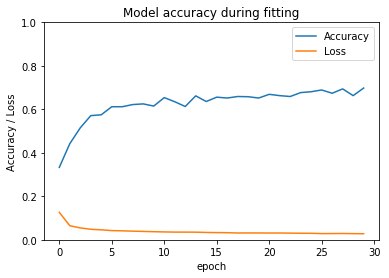

Creating dataset:   0%|          | 0/300 [00:00<?, ?it/s]

Creating dataset:   3%|▎         | 8/300 [00:00<00:03, 75.53it/s]

Creating dataset:   5%|▌         | 15/300 [00:00<00:03, 72.19it/s]

Creating dataset:   8%|▊         | 23/300 [00:00<00:03, 73.16it/s]

Creating dataset:  10%|█         | 31/300 [00:00<00:03, 73.24it/s]

Creating dataset:  12%|█▏        | 37/300 [00:00<00:03, 67.78it/s]

Creating dataset:  15%|█▍        | 44/300 [00:00<00:03, 67.45it/s]

Creating dataset:  17%|█▋        | 52/300 [00:00<00:03, 69.87it/s]

Creating dataset:  20%|██        | 60/300 [00:00<00:03, 71.86it/s]

Creating dataset:  23%|██▎       | 68/300 [00:00<00:03, 72.72it/s]

Creating dataset:  25%|██▌       | 76/300 [00:01<00:03, 72.53it/s]

Creating dataset:  28%|██▊       | 84/300 [00:01<00:02, 73.40it/s]

Creating dataset:  31%|███       | 92/300 [00:01<00:02, 74.03it/s]

Creating dataset:  33%|███▎      | 100/300 [00:01<00:02, 74.26it/s]

Creating dataset:  36%|███▌      | 108/300 [00:01<00:02, 73.60it/s]

Creating dataset:  39%|███▊      | 116/300 [00:01<00:02, 73.55it/s]

Creating dataset:  41%|████▏     | 124/300 [00:01<00:02, 74.37it/s]

Creating dataset:  44%|████▍     | 132/300 [00:01<00:02, 74.71it/s]

Creating dataset:  47%|████▋     | 140/300 [00:01<00:02, 73.50it/s]

Creating dataset:  49%|████▉     | 148/300 [00:02<00:02, 72.68it/s]

Creating dataset:  52%|█████▏    | 156/300 [00:02<00:01, 72.90it/s]

Creating dataset:  55%|█████▍    | 164/300 [00:02<00:01, 73.67it/s]

Creating dataset:  57%|█████▋    | 172/300 [00:02<00:01, 69.93it/s]

Creating dataset:  60%|██████    | 180/300 [00:02<00:01, 68.76it/s]

Creating dataset:  63%|██████▎   | 188/300 [00:02<00:01, 70.65it/s]

Creating dataset:  65%|██████▌   | 196/300 [00:02<00:01, 71.65it/s]

Creating dataset:  68%|██████▊   | 204/300 [00:02<00:01, 72.57it/s]

Creating dataset:  71%|███████   | 212/300 [00:02<00:01, 72.63it/s]

Creating dataset:  73%|███████▎  | 220/300 [00:03<00:01, 72.28it/s]

Creating dataset:  76%|███████▌  | 228/300 [00:03<00:00, 72.82it/s]

Creating dataset:  79%|███████▊  | 236/300 [00:03<00:00, 73.20it/s]

Creating dataset:  81%|████████▏ | 244/300 [00:04<00:03, 15.40it/s]

Creating dataset:  84%|████████▍ | 252/300 [00:04<00:02, 20.24it/s]

Creating dataset:  86%|████████▋ | 259/300 [00:04<00:01, 25.31it/s]

Creating dataset:  89%|████████▉ | 267/300 [00:05<00:01, 31.58it/s]

Creating dataset:  92%|█████████▏| 275/300 [00:05<00:00, 38.31it/s]

Creating dataset:  94%|█████████▍| 283/300 [00:05<00:00, 44.88it/s]

Creating dataset:  97%|█████████▋| 291/300 [00:05<00:00, 51.10it/s]

Creating dataset: 100%|█████████▉| 299/300 [00:05<00:00, 56.47it/s]

Creating dataset: 100%|██████████| 300/300 [00:05<00:00, 54.46it/s]

***** Results on the test dataset *****

Loss: 0.028518194407224653 | Accuracy: 0.7500000007947286

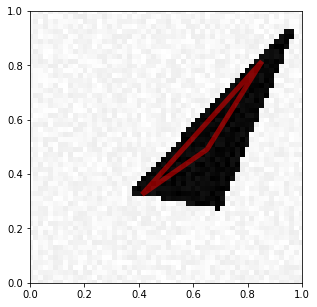

[[0.41221735 0.32514638 0.65095603 0.49062985 0.8530636  0.8145927 ]]

In [17]:

[X_train, Y_train] = generate_dataset_regression(1000, 10)
Y_train = normalize_output_reg3(Y_train)

model_reg, history_reg = regression_model2(X_train, Y_train, 'sgd', epochs=30, verbose=False, learning_rate=0.05)
plot_history(history_reg)

[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
Y_test = normalize_output_reg3(Y_test)

print('***** Results on the test dataset *****')
evaluation = model_reg.evaluate(X_test, Y_test, verbose=False)
print('Loss: %s | Accuracy: %s' % (evaluation[0], evaluation[1]))

visualize_prediction(X_test[0], model_reg.predict(np.array([X_test[0]])))
print(model_reg.predict([[X_test[0]]]))


### 7. Image Denoising

For the denoising task, I tride to implement a light Autoencoder, by stacking 2 convolutions and 2 deconvolutions in the network. 

Unfortunately, my computer did not allow me to give to the model a huge amount of data, thus, I only gave to this network 50 training data. Though, it already gave me an accuracy of 0.8 on the training set (as shown below), and 0.9 on the test dataset.

Using TensorFlow backend.


Creating dataset:   0%|          | 0/50 [00:00<?, ?it/s]

Creating dataset:   8%|▊         | 4/50 [00:00<00:01, 36.72it/s]

Creating dataset:  12%|█▏        | 6/50 [00:00<00:01, 23.89it/s]

Creating dataset:  20%|██        | 10/50 [00:00<00:01, 25.71it/s]

Creating dataset:  26%|██▌       | 13/50 [00:00<00:01, 26.80it/s]

Creating dataset:  34%|███▍      | 17/50 [00:00<00:01, 28.18it/s]

Creating dataset:  42%|████▏     | 21/50 [00:00<00:00, 30.22it/s]

Creating dataset:  48%|████▊     | 24/50 [00:00<00:00, 29.98it/s]

Creating dataset:  56%|█████▌    | 28/50 [00:00<00:00, 31.50it/s]

Creating dataset:  64%|██████▍   | 32/50 [00:01<00:00, 31.65it/s]

Creating dataset:  72%|███████▏  | 36/50 [00:01<00:00, 26.36it/s]

Creating dataset:  80%|████████  | 40/50 [00:01<00:00, 28.68it/s]

Creating dataset:  88%|████████▊ | 44/50 [00:01<00:00, 30.76it/s]

Creating dataset:  96%|█████████▌| 48/50 [00:01<00:00, 31.57it/s]

Creating dataset: 100%|██████████| 50/50 [00:01<00:00, 29.90it/s]

Image size : 72 * 72

Output shape = (None, 63, 63, 6)

Output shape = (None, 54, 54, 16)

Output shape = (None, 63, 63, 8)

Output shape = (None, 72, 72, 1)

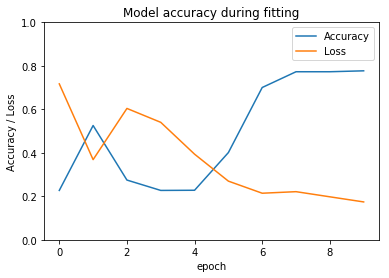

In [1]:
dataset_size = 50

[X_train, Y_train] = generate_dataset_denoising(dataset_size, 20)

model_denois, history_denois = denoising_model(X_train, Y_train, 'sgd', epochs=10, verbose=False, learning_rate=0.01)
plot_history(history_denois)


In [3]:
[X_test, Y_test] = generate_test_set_denoising()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

evaluation = model_denois.evaluate(X_test, Y_test, verbose=False)
print('***** Results on the test dataset *****')
print('Loss: %s | Accuracy: %s' % (evaluation[0], evaluation[1]))


Creating dataset:   0%|          | 0/300 [00:00<?, ?it/s]

Creating dataset:   2%|▏         | 5/300 [00:00<00:06, 43.88it/s]

Creating dataset:   4%|▍         | 12/300 [00:00<00:05, 49.11it/s]

Creating dataset:   6%|▋         | 19/300 [00:00<00:05, 53.57it/s]

Creating dataset:   9%|▊         | 26/300 [00:00<00:04, 56.12it/s]

Creating dataset:  11%|█         | 33/300 [00:00<00:04, 58.77it/s]

Creating dataset:  14%|█▎        | 41/300 [00:00<00:04, 62.08it/s]

Creating dataset:  16%|█▌        | 47/300 [00:00<00:04, 55.80it/s]

Creating dataset:  18%|█▊        | 53/300 [00:00<00:04, 55.27it/s]

Creating dataset:  20%|██        | 61/300 [00:01<00:04, 58.78it/s]

Creating dataset:  23%|██▎       | 68/300 [00:01<00:03, 61.60it/s]

Creating dataset:  25%|██▌       | 76/300 [00:01<00:03, 64.42it/s]

Creating dataset:  28%|██▊       | 83/300 [00:01<00:03, 65.45it/s]

Creating dataset:  30%|███       | 90/300 [00:01<00:06, 31.52it/s]

Creating dataset:  33%|███▎      | 98/300 [00:01<00:05, 38.09it/s]

Creating dataset:  35%|███▌      | 106/300 [00:02<00:04, 44.44it/s]

Creating dataset:  38%|███▊      | 114/300 [00:02<00:03, 50.22it/s]

Creating dataset:  41%|████      | 122/300 [00:02<00:03, 55.48it/s]

Creating dataset:  43%|████▎     | 130/300 [00:02<00:02, 60.01it/s]

Creating dataset:  46%|████▌     | 138/300 [00:02<00:02, 63.19it/s]

Creating dataset:  49%|████▊     | 146/300 [00:02<00:03, 50.96it/s]

Creating dataset:  51%|█████▏    | 154/300 [00:02<00:02, 55.88it/s]

Creating dataset:  54%|█████▍    | 162/300 [00:02<00:02, 59.69it/s]

Creating dataset:  57%|█████▋    | 170/300 [00:03<00:02, 63.09it/s]

Creating dataset:  59%|█████▉    | 178/300 [00:03<00:01, 65.55it/s]

Creating dataset:  62%|██████▏   | 185/300 [00:03<00:01, 66.65it/s]

Creating dataset:  64%|██████▍   | 192/300 [00:03<00:01, 66.67it/s]

Creating dataset:  67%|██████▋   | 200/300 [00:03<00:01, 68.04it/s]

Creating dataset:  69%|██████▉   | 207/300 [00:03<00:01, 67.83it/s]

Creating dataset:  71%|███████▏  | 214/300 [00:03<00:01, 48.44it/s]

Creating dataset:  74%|███████▍  | 222/300 [00:03<00:01, 53.95it/s]

Creating dataset:  77%|███████▋  | 230/300 [00:04<00:01, 58.36it/s]

Creating dataset:  79%|███████▉  | 238/300 [00:04<00:01, 61.62it/s]

Creating dataset:  82%|████████▏ | 245/300 [00:04<00:00, 63.43it/s]

Creating dataset:  84%|████████▍ | 253/300 [00:04<00:00, 65.64it/s]

Creating dataset:  87%|████████▋ | 261/300 [00:04<00:00, 66.95it/s]

Creating dataset:  89%|████████▉ | 268/300 [00:04<00:00, 66.69it/s]

Creating dataset:  92%|█████████▏| 276/300 [00:04<00:00, 68.05it/s]

Creating dataset:  95%|█████████▍| 284/300 [00:04<00:00, 68.69it/s]

Creating dataset:  97%|█████████▋| 292/300 [00:04<00:00, 69.32it/s]

Creating dataset: 100%|█████████▉| 299/300 [00:05<00:00, 44.83it/s]

Creating dataset: 100%|██████████| 300/300 [00:05<00:00, 57.52it/s]

***** Results on the test dataset *****

Loss: 0.08810839623212814 | Accuracy: 0.9131134160359701

In the figure below is shown an exemple of the results obtained on the test dataset by the denoising network. Unfortunaltely, because of the few number of training data, the results are far from being great. But we already observe that the picture is quite averaged.

We can also observe edges effects, probably du to the convolutions, used wiith a 'valid' padding, which implies an asymetric treatment for the edges of the picture. And Finally, we see a 'blur' effect on the shape, which is classical on denoising tasks.

Text(0.5, 1.0, 'Predicted Images')

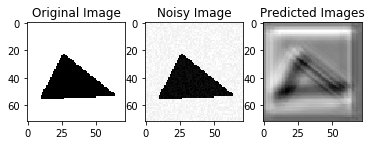

In [4]:
idx = 95
Y_pred = model_denois.predict(X_test[idx].reshape(1, 72, 72, 1))

plt.figure()
plt.subplot(131)
plt.imshow(Y_test[idx].reshape(72, 72), cmap='gray')
plt.title("Original Image")

plt.subplot(132)
plt.imshow(X_test[idx].reshape(72, 72), cmap='gray')
plt.title("Noisy Image")

plt.subplot(133)
plt.imshow(Y_pred.reshape(72, 72), cmap='gray')
plt.title("Predicted Images")
